In [1]:
import numpy as np
import scipy as sp
import torch
import time
import copy
import pickle
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import os
import sys
import cvxpy as cp
from itertools import product
sys.path.insert(0, os.path.abspath('../../'))

In [2]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Create data

In [3]:
def mixture_of_Gaussians(n, n_features, std_, means, nodes_per_mean):
    
    # Create sample from mixture of Gaussians
    X = np.zeros((2*n,n_features))
    for ct, mean_ in enumerate(means):            
        X[nodes_per_mean[ct],:] = std_ * np.random.randn(len(nodes_per_mean[ct]), n_features) + mean_
    X_ = np.zeros((2*n,n_features+1))
    X_[:,:-1] = X
    X_[:,-1]  = np.ones(2*n)
    
    # labels
    y = np.zeros(2*n)
    y[0:n] = 1
    
    return X_, y

def sbm_mixture_of_Gaussians(n, n_features, sizes, probs, std_, means, nodes_per_mean):
    
    # Create matrix related to the graph
    g = nx.stochastic_block_model(sizes, probs)
    A = nx.adjacency_matrix(g)
    A.setdiag(A.diagonal() + 1)
    d_mat = np.sum(A, axis=0)
    dinv_mat = 1/d_mat
    d = d_mat.tolist()[0]
    dinv = dinv_mat.tolist()[0]
    D = sp.sparse.diags(d, 0)
    Dinv = sp.sparse.diags(dinv, 0)
    
    # Create sample from mixture of Gaussians
    X = np.zeros((2*n,n_features))
    for ct, mean_ in enumerate(means):            
        X[nodes_per_mean[ct],:] = std_ * np.random.randn(len(nodes_per_mean[ct]), n_features) + mean_

    # Create data
    data_ = Dinv@A@X

    # Append a column of ones for the coefficients of the bias
    data = np.zeros((2*n,n_features+1))
    data[:,:-1] = data_
    data[:,-1]  = np.ones(2*n)
    
    # labels
    y = np.zeros(2*n)
    y[0:n] = 1
    
    return data, y

# Create training and testing data

In [4]:
# Dimensions
n = 200
n_features = 5*int(np.ceil(2*n/(np.log(2*n)**2))) # 10*int(np.ceil(np.log(2*n)))

# Parameters for SBM
ps = [0.5, 0.7, 0.9, 1]
qs = list(np.linspace(0.1, 1, 20, endpoint=True))

# Number of trials
trials = 10

# Means
mus = [8/n_features, 1/n_features]
all_means = {}

In [5]:
train_datasets_per_mean = {}
train_datasets_log_per_mean = {}
test_datasets_per_mean = {}
test_datasets_log_per_mean = {}

for mu in mus:
    # Parameters for mixture of Gaussians
    std_ = 1/np.sqrt(n_features)
    means = [mu,-mu]
    nodes_per_mean = [list(range(n)),list(range(n,2*n))]
    all_means[mu] = means
    # Train datasets without the graph
    train_datasets_log = {}
    for trial in range(trials):
        X, y = mixture_of_Gaussians(n, n_features, std_, means, nodes_per_mean)
        train_datasets_log[trial] = [X, y]
    train_datasets_log_per_mean[mu] = train_datasets_log
    # Train datasets with the graph
    train_datasets = {}
    for p in ps:
        for q in qs:
            if q > p:
                continue
            for trial in range(trials):
                # SBM parameters
                probs = [[p, q], [q, p]]
                sizes = [n, n]
                # Training data
                X, y = sbm_mixture_of_Gaussians(n, n_features, sizes, probs, std_, means, nodes_per_mean)
                train_datasets[(p,q,trial)] = [X, y]
    train_datasets_per_mean[mu] = train_datasets

    # Test datasets
    test_datasets_log = {}
    for trial in range(trials):
        # Training data
        X, y = mixture_of_Gaussians(n, n_features, std_, means, nodes_per_mean)
        test_datasets_log[trial] = [X, y]
    test_datasets_log_per_mean[mu] = test_datasets_log

    test_datasets = {}
    for p in ps:
        for q in qs:
            if q > p:
                continue
            for trial in range(trials):
                # SBM parameters
                probs = [[p, q], [q, p]]
                sizes = [n, n]
                # Training data
                X, y = sbm_mixture_of_Gaussians(n, n_features, sizes, probs, std_, means, nodes_per_mean)
                test_datasets[(p,q,trial)] = [X, y]
    test_datasets_per_mean[mu] = train_datasets

/Users/aseemrb/opt/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


# Solver

In [6]:
def ipm(n, n_features, max_iter, data, y, verbose):

## Changed to CVX to get better accuracy because simple GD sucks.
    w = cp.Variable(n_features + 1)    
    log_likelihood = (cp.sum(cp.multiply(y, data @ w) - cp.logistic(data @ w)))/(2*n)
    objective = cp.Maximize(log_likelihood)
    constraints = [cp.norm(w[0:n_features],2) <= n_features]
    prob = cp.Problem(objective, constraints)
    result = prob.solve(solver='ECOS', verbose = verbose, reltol=1.0e-10, abstol=1.0e-10, feastol=1.0e-10, max_iters=max_iter)
#     result = prob.solve(solver='SCS', eps=1.0e-10, verbose = verbose, max_iters=max_iter)
    
    return w.value

# Do training

In [7]:
all_w_per_mean_log = {}
plots_log = {}
for mu in mus:
    train_datasets = train_datasets_log_per_mean[mu]
    all_w_log = {}
    avg_log = 0
    for trial in range(trials):
        [X, y] = train_datasets[trial]
        w_log = ipm(n, n_features, 100, X, y, False)
        all_w_log[trial] = w_log
        # Compute the loss for "without the graph"
        sigma = 1/(1+np.exp(-X@w_log))
        avg_log += np.sum(-y*np.log(sigma + 1.0e-12) - (1-y)*np.log(1-sigma + 1.0e-12))/(2*n)
    avg_log /= trials
    all_w_per_mean_log[mu] = all_w_log
    plots_log[mu] = avg_log*np.ones(len(qs))
    print("distance: ", 2*mu*np.sqrt(n_features), " obj (without graph): ", avg_log)

all_w_per_mean = {}
plots = {}
for mu in mus:
    train_datasets = train_datasets_per_mean[mu]
    all_w = {}
    p_lines = {}
    for p in ps:
        p_line = []
        for ct, q in enumerate(qs):
            if q > p: 
                continue
            avg = 0
            for trial in range(trials):
                [X, y] = train_datasets[(p,q,trial)]
                w = ipm(n, n_features, 100, X, y, False)
                all_w[(p,q,trial)] = w
                # Compute the loss for "with the graph"
                sigma = 1/(1+np.exp(-X@w))
                avg += np.sum(-y*np.log(sigma + 1.0e-12) - (1-y)*np.log(1-sigma + 1.0e-12))/(2*n) 
            avg /= trials
            p_line.append(avg)
            print("distance: ", 2*mu*np.sqrt(n_features), "p: ", p, " q: ", q, " obj (with graph): ", avg)
        p_lines[p] = p_line
    plots[mu] = p_lines
    all_w_per_mean[mu] = all_w

/Users/aseemrb/opt/anaconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1245: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
distance:  2.0655911179772892  obj (without graph):  2.074497921731895e-07
distance:  0.25819888974716115  obj (without graph):  0.25350962908642505
distance:  2.0655911179772892 p:  0.5  q:  0.1  obj (with graph):  2.0929890956144993e-07
distance:  2.0655911179772892 p:  0.5  q:  0.1473684210526316  obj (with graph):  2.3340714733949356e-07
distance:  2.0655911179772892 p:  0.5  q:  0.19473684210526315  obj (with graph):  2.968322460536274e-07
distance:  2.0655911179772892 p:  0.5  q:  0.24210526315789474  obj (with graph):  4.549376015561655e-07
distance:  2.0655911179772892 p:  0.5  q:  0.2894736842105263  obj (with graph):  2.248295177853479e-05
distance:  2.0655911179772892 p:  0.5  q:  0.33684210526315794  obj (with graph):  0.0009836981

# Compute test errors without the graph

In [8]:
plots_log_test = {}
for mu in mus:
    test_datasets = test_datasets_log_per_mean[mu]
    all_w_log = all_w_per_mean_log[mu]
    avg_log = 0
    for trial, trial2 in product(range(trials),range(trials)):
        [X, y] = test_datasets[trial2]
        w_log = all_w_log[trial]
        # Compute the loss for "without the graph"
        sigma = 1/(1+np.exp(-X@w_log))
        avg_log += np.sum(-y*np.log(sigma + 1.0e-12) - (1-y)*np.log(1-sigma + 1.0e-12))/(2*n) #obj/(2*n)  
    avg_log /= trials**2
    plots_log_test[mu] = avg_log*np.ones(len(qs))
    print("distance: ", 2*mu*np.sqrt(n_features), " obj (without graph): ", avg_log)

distance:  2.0655911179772892  obj (without graph):  1.0719953965032831e-06
distance:  0.25819888974716115  obj (without graph):  0.5517828917849694


# Compute test errors with the graph

In [9]:
l_trials = list(range(trials))
plots_test_ood = {}
for mu in mus:
    print("mu: ", mu)
    test_datasets = test_datasets_per_mean[mu]
    all_w = all_w_per_mean[mu]
    
    for p, q, trial in product(ps, qs, l_trials):
        if p < q:
            continue
        w = all_w[(p,q,trial)]
        for p2, q2, trial2 in product(ps, qs, l_trials):
            if p2 < q2:
                continue
            [X, y] = test_datasets[(p2,q2,trial2)]
            # Compute the loss for "with the graph"
            sigma = 1/(1+np.exp(-X@w))
            obj = np.sum(-y*np.log(sigma + 1.0e-12) - (1-y)*np.log(1-sigma + 1.0e-12))/(2*n)
            plots_test_ood[(mu,p,q,trial,p2,q2,trial2)] = obj

mu:  0.13333333333333333
mu:  0.016666666666666666


# Compute data for plots

In [11]:
plots_pq = {}
for mu in mus:
    for p, q in product(ps, qs):
        if p < q:
            continue
        p_lines = {}
        for p2 in ps:
            p_line = []
            for q2 in qs:
                if p2 < q2:
                    continue
                avg = 0
                for trial in range(trials):
                    for trial2 in range(trials):
                        avg += plots_test_ood[(mu,p,q,trial,p2,q2,trial2)]
                avg /= trials**2
                p_line.append(avg)
            p_lines[p2] = p_line
        plots_pq[(mu,p,q)] = p_lines

# Plot test on different distribution

Distance:  2.07
Trained on (p,q): (0.5, 0.1)


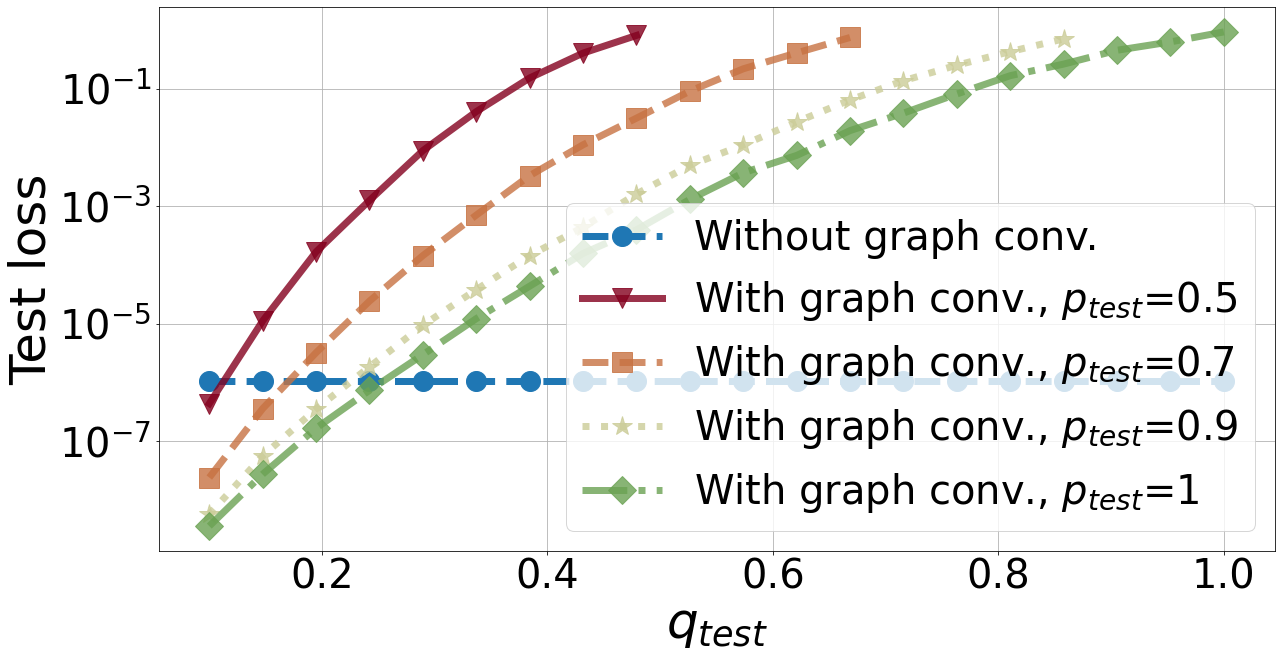

Trained on (p,q): (0.5, 0.38421052631578945)


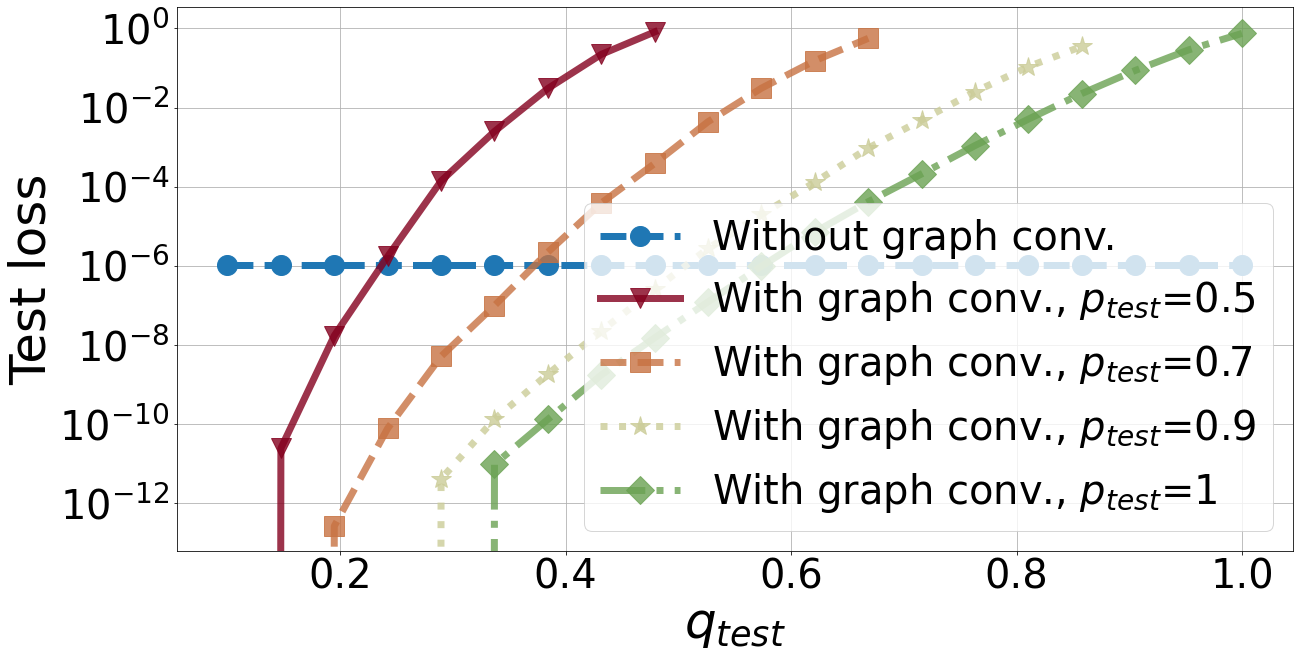

Trained on (p,q): (0.7, 0.1)


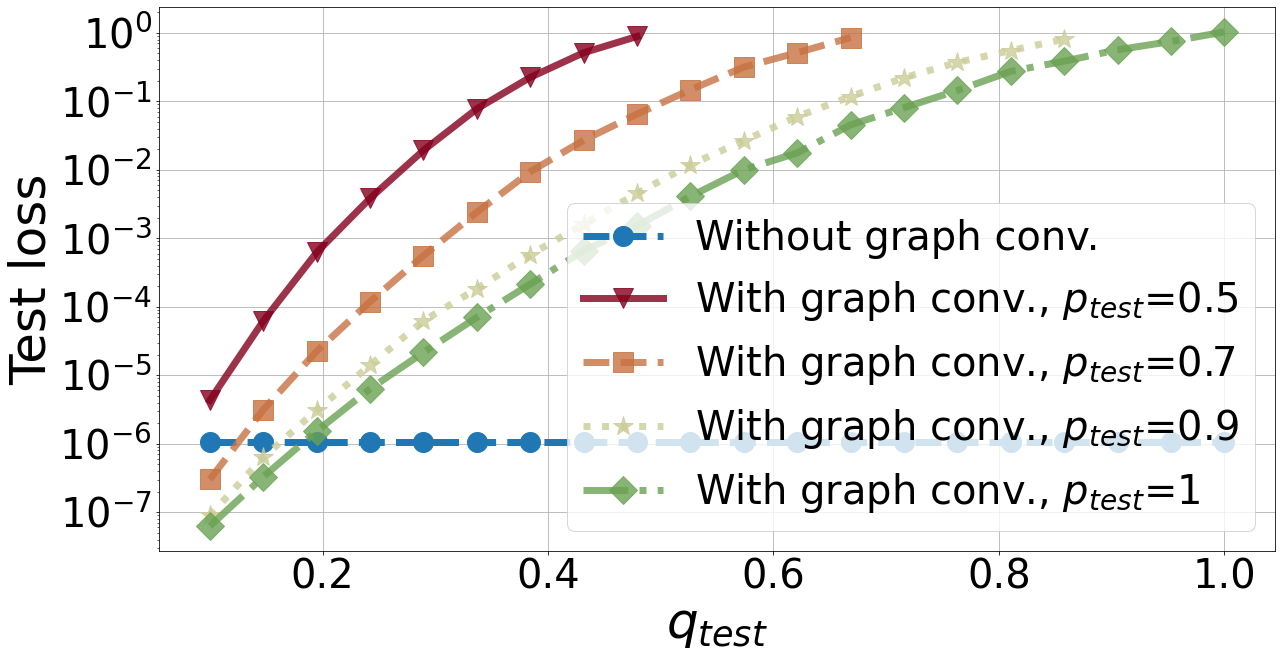

Trained on (p,q): (0.7, 0.38421052631578945)


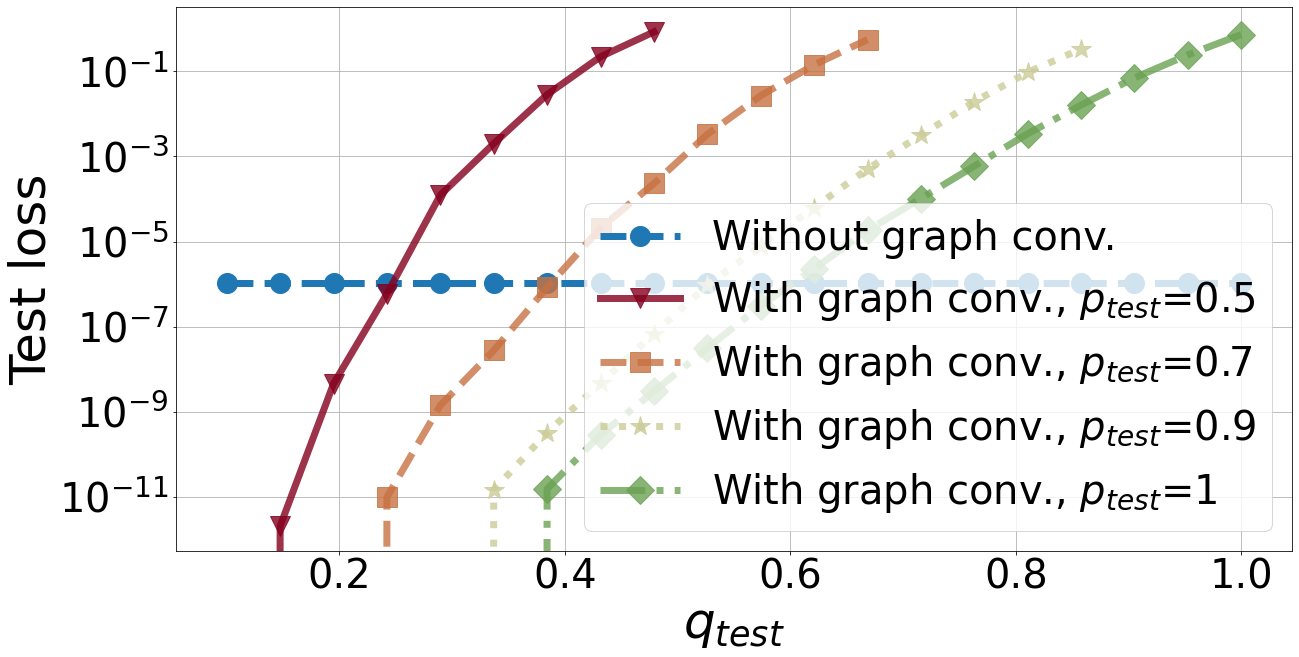

Trained on (p,q): (0.7, 0.6684210526315789)


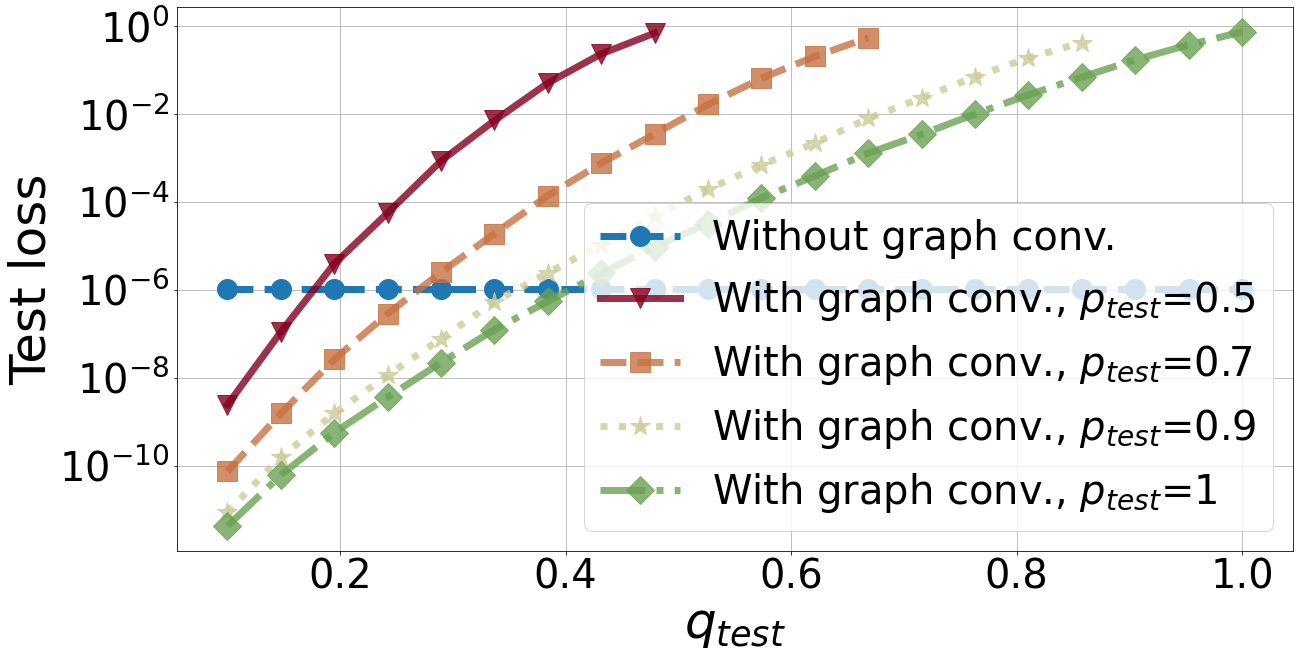

Trained on (p,q): (0.9, 0.1)


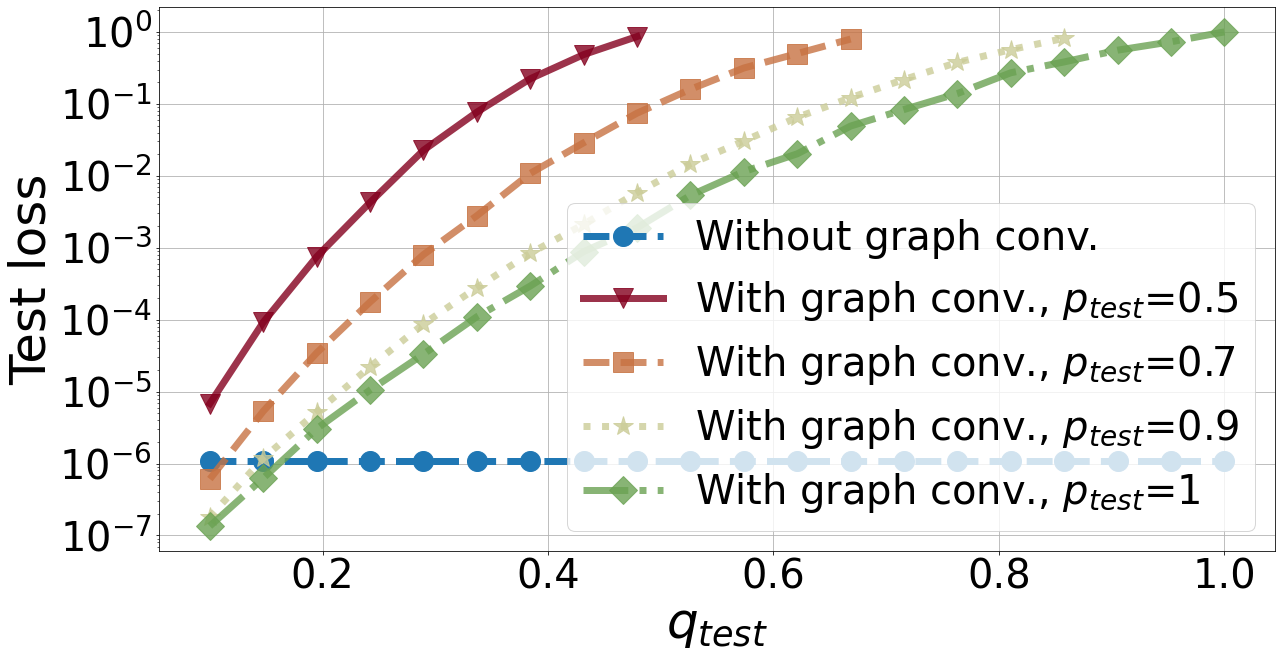

Trained on (p,q): (0.9, 0.38421052631578945)


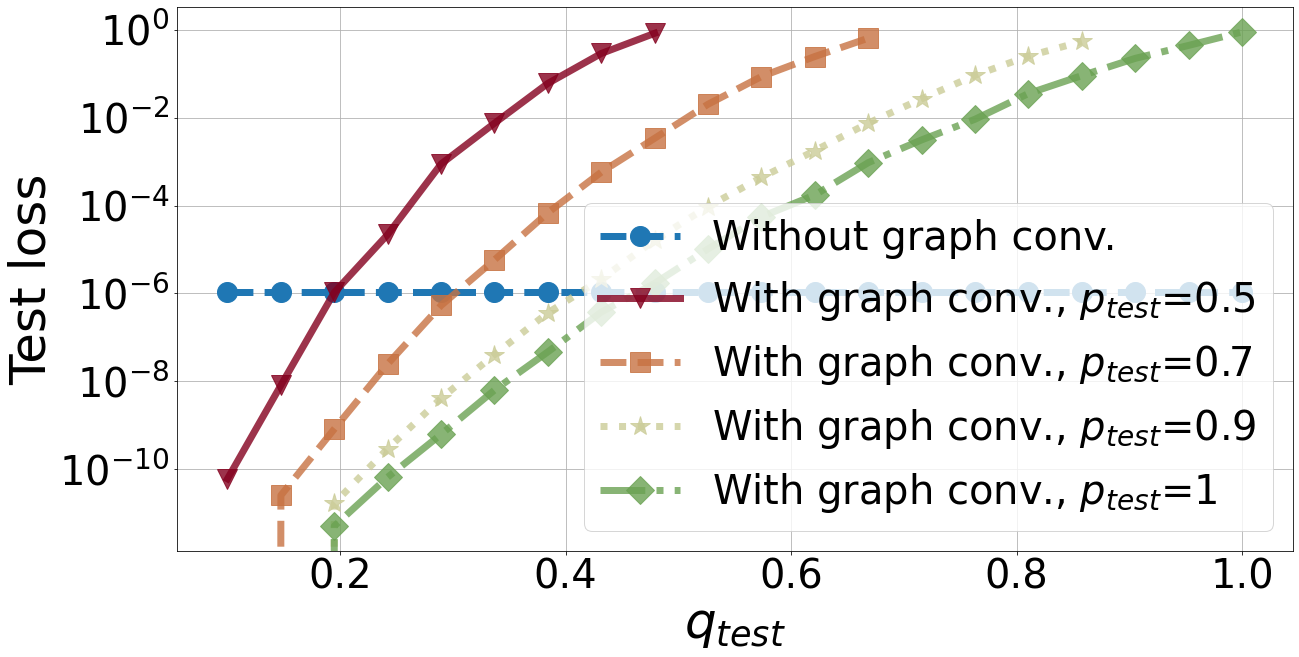

Trained on (p,q): (0.9, 0.6684210526315789)


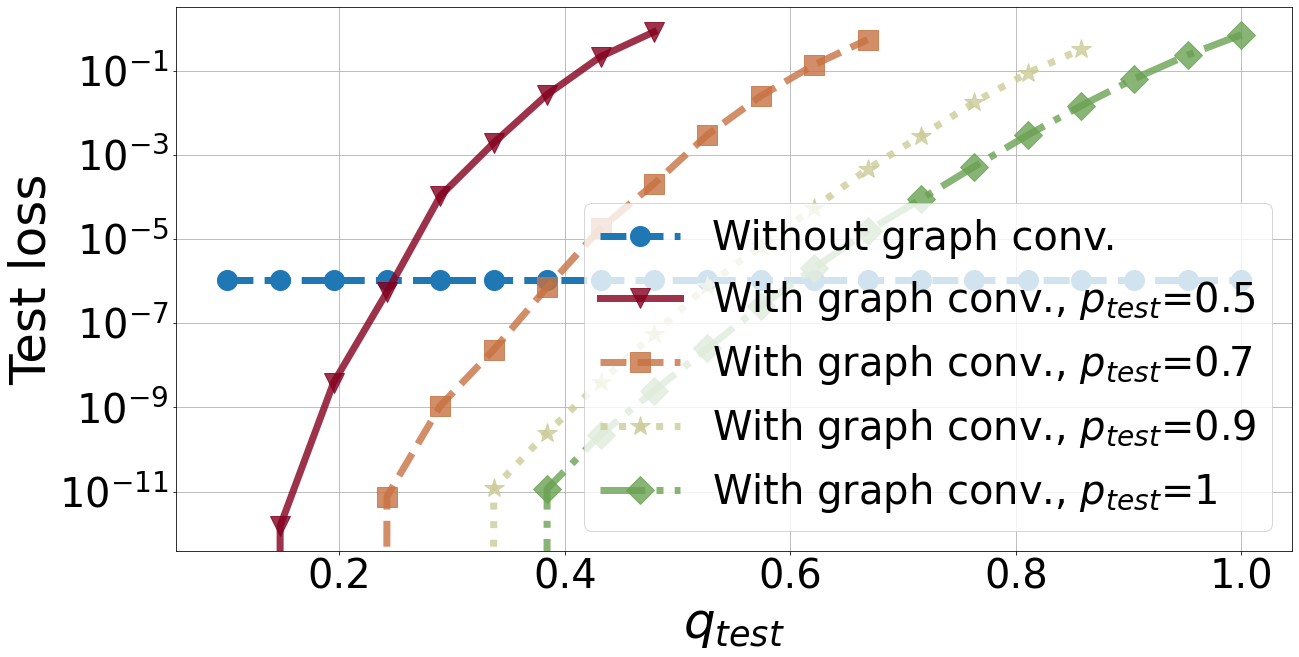

Trained on (p,q): (1, 0.1)


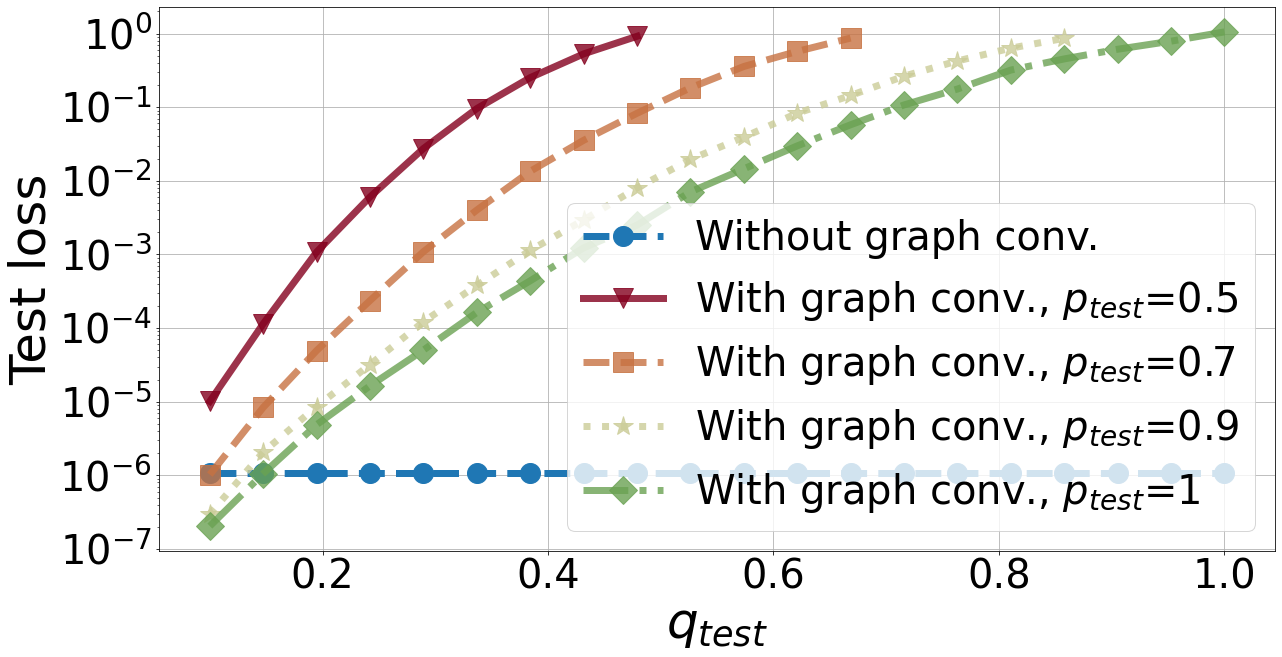

Trained on (p,q): (1, 0.38421052631578945)


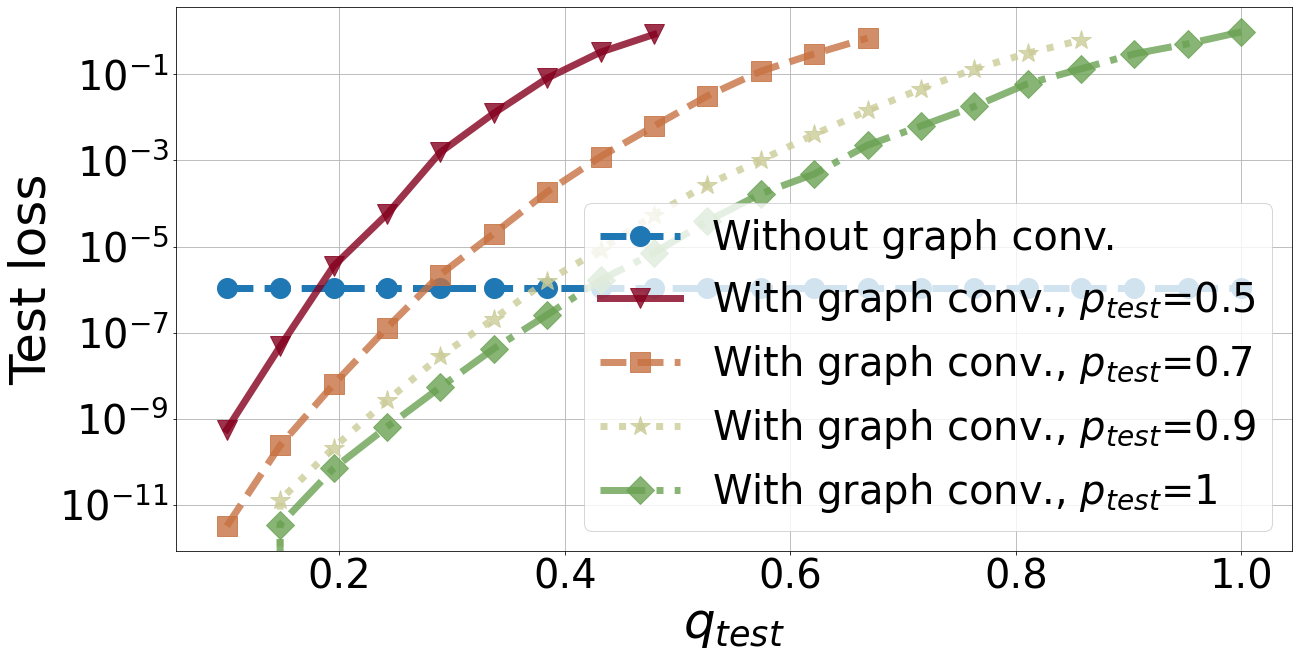

Trained on (p,q): (1, 0.6684210526315789)


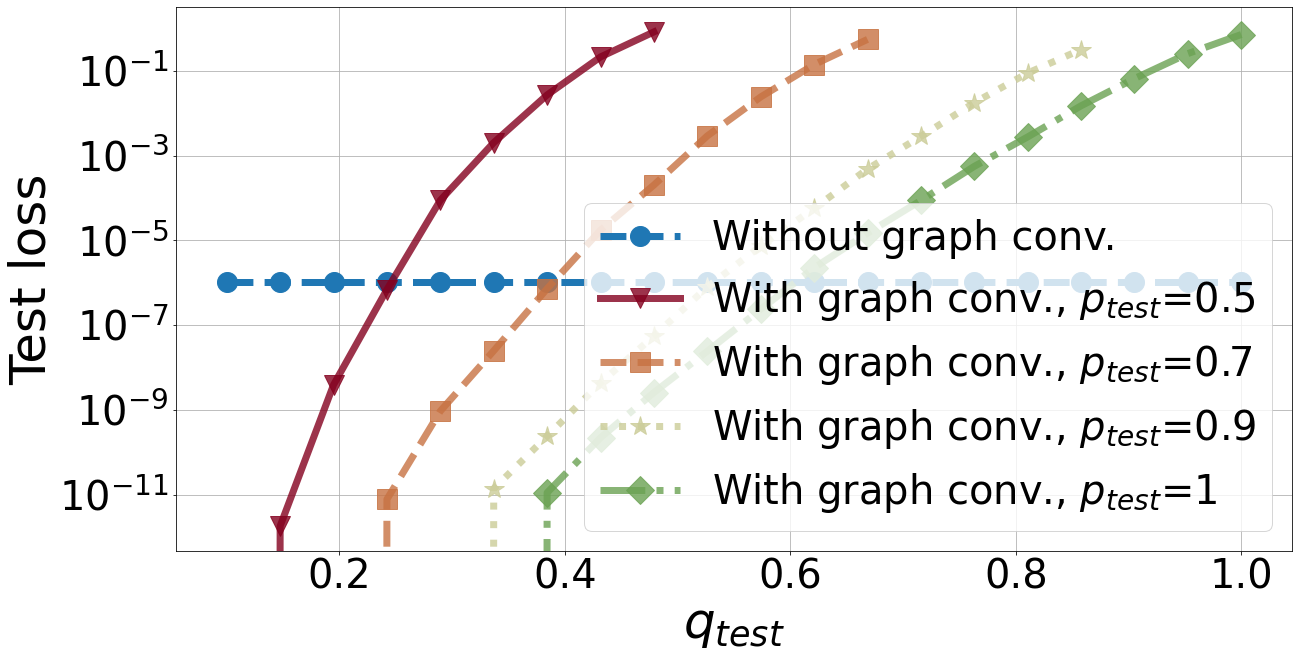

Trained on (p,q): (1, 0.9526315789473684)


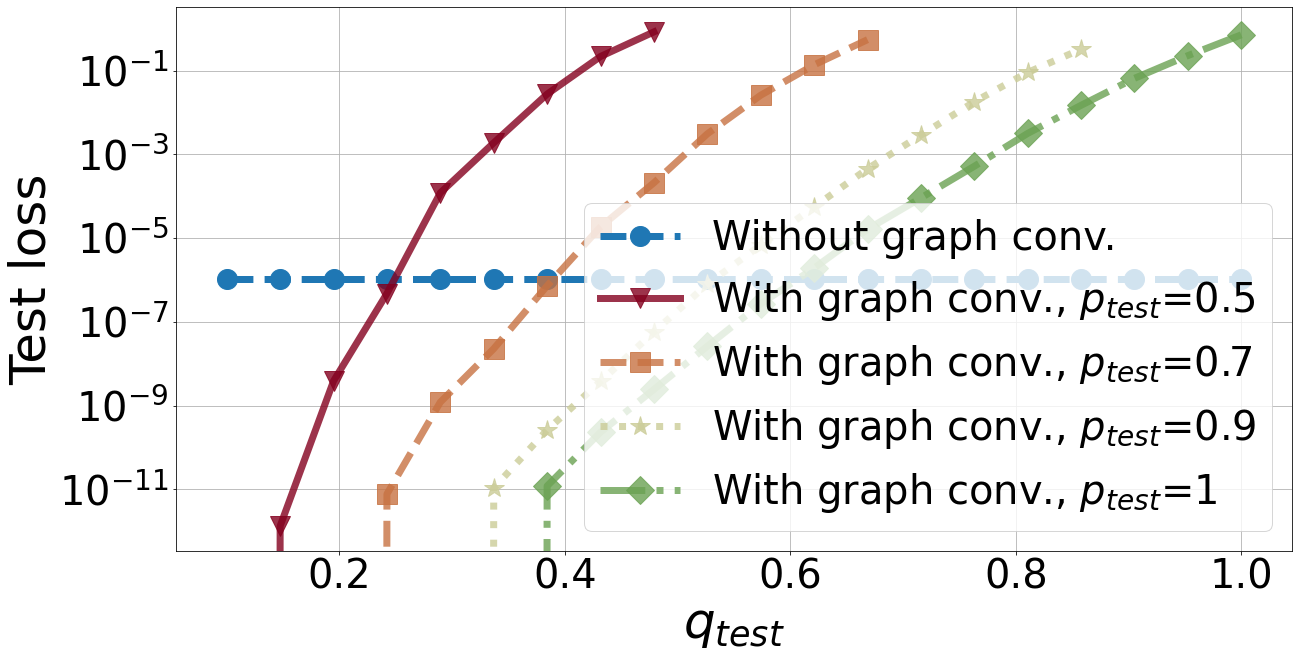

Distance:  0.26
Trained on (p,q): (0.5, 0.1)


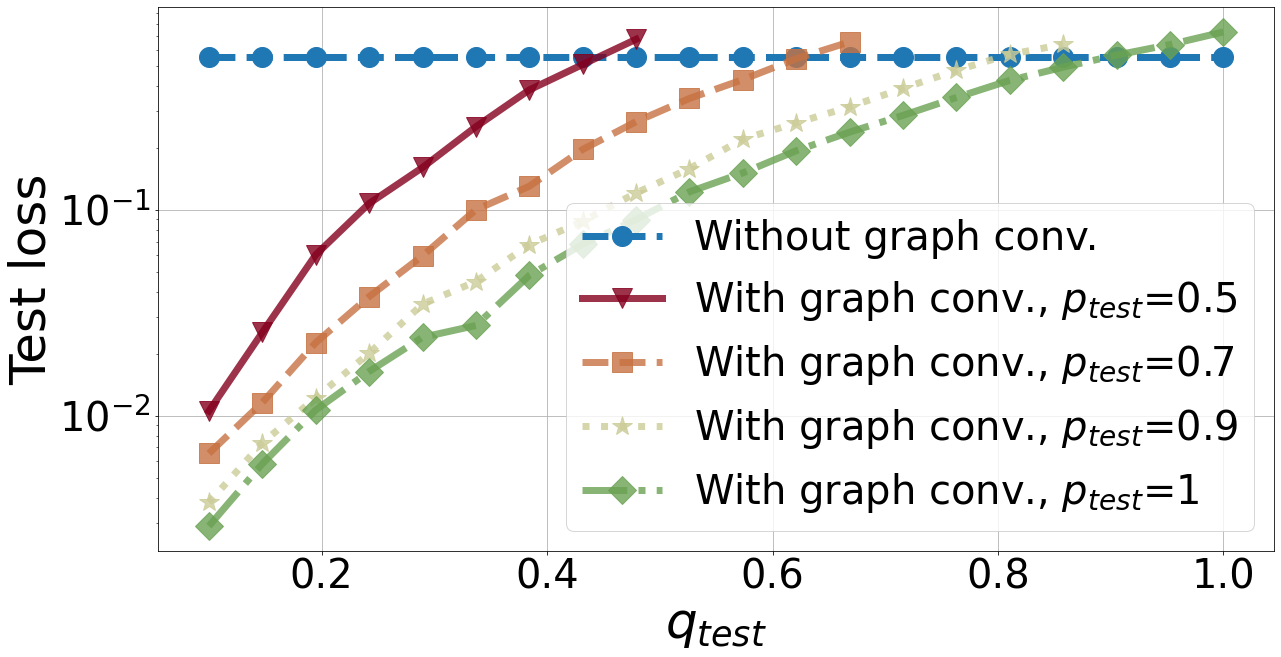

Trained on (p,q): (0.5, 0.38421052631578945)


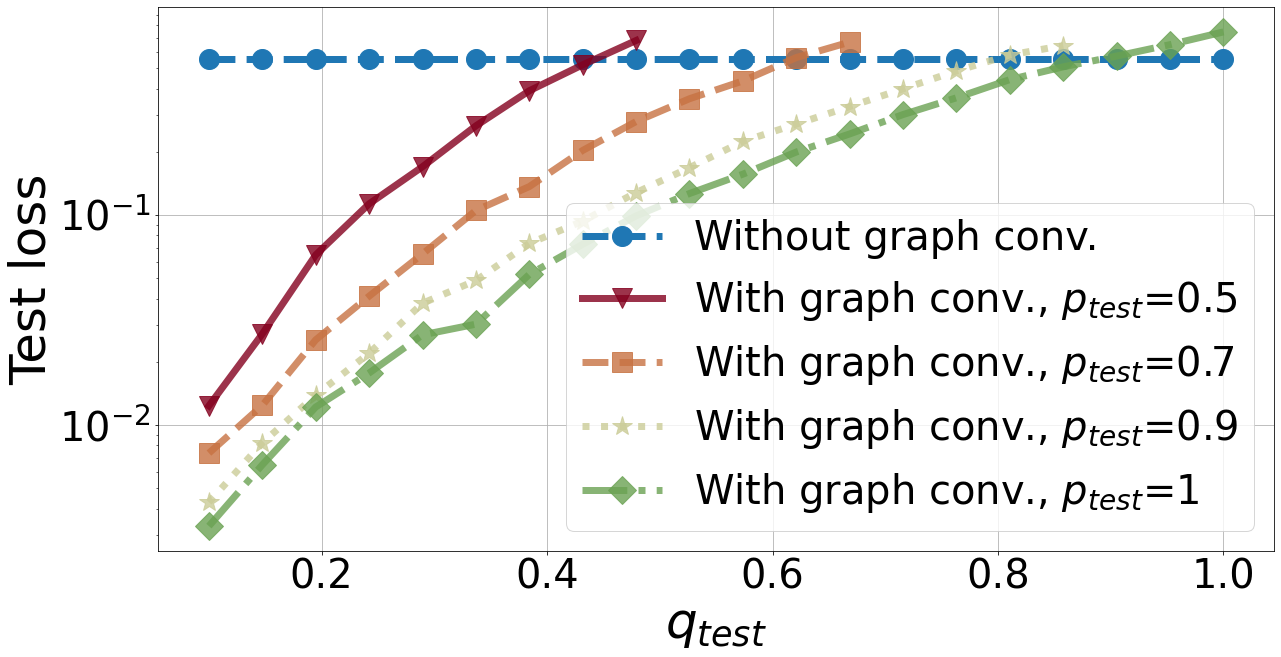

Trained on (p,q): (0.7, 0.1)


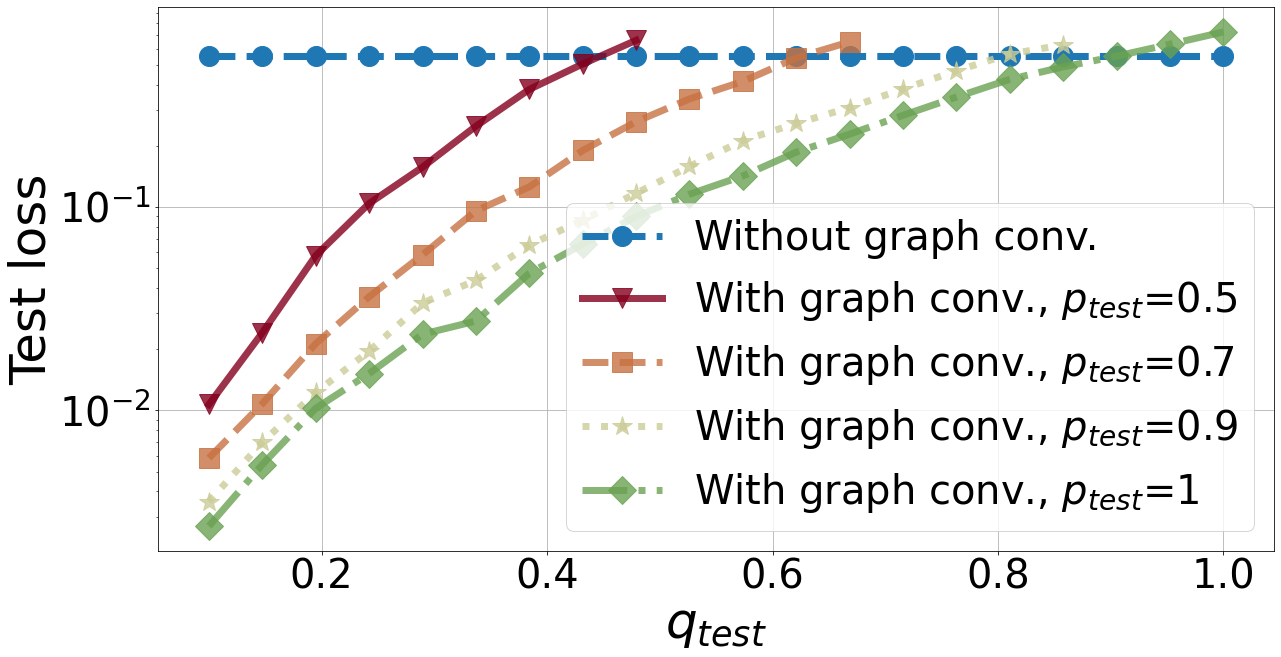

Trained on (p,q): (0.7, 0.38421052631578945)


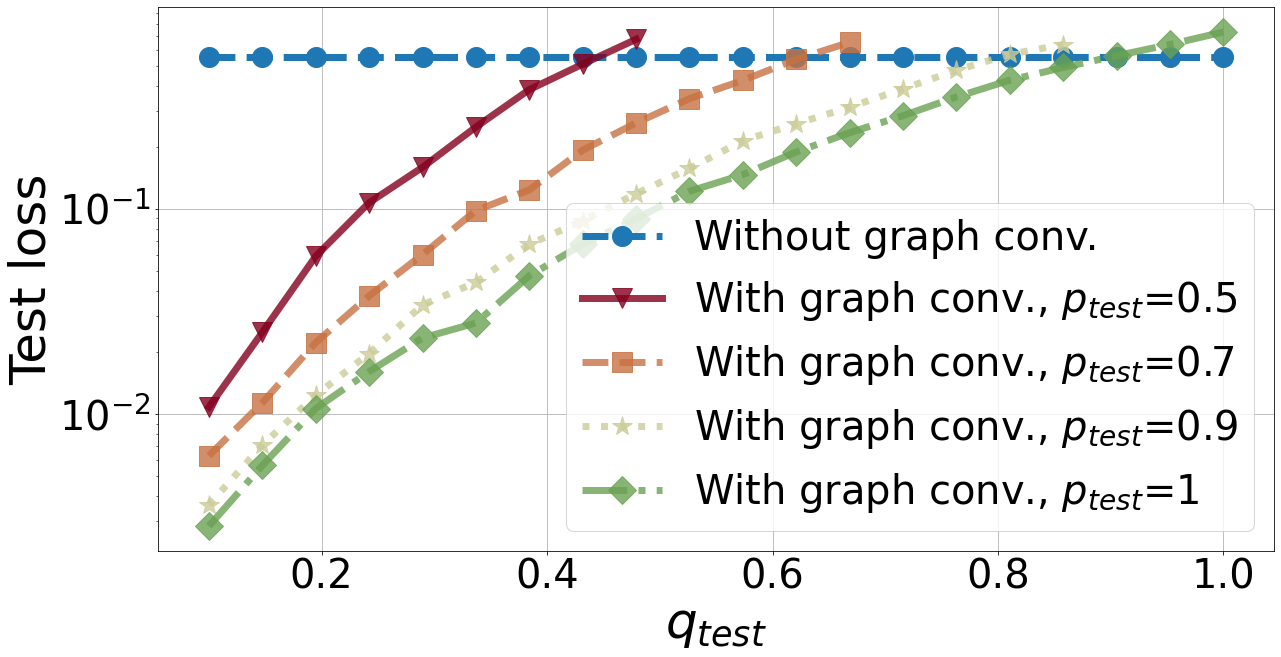

Trained on (p,q): (0.7, 0.6684210526315789)


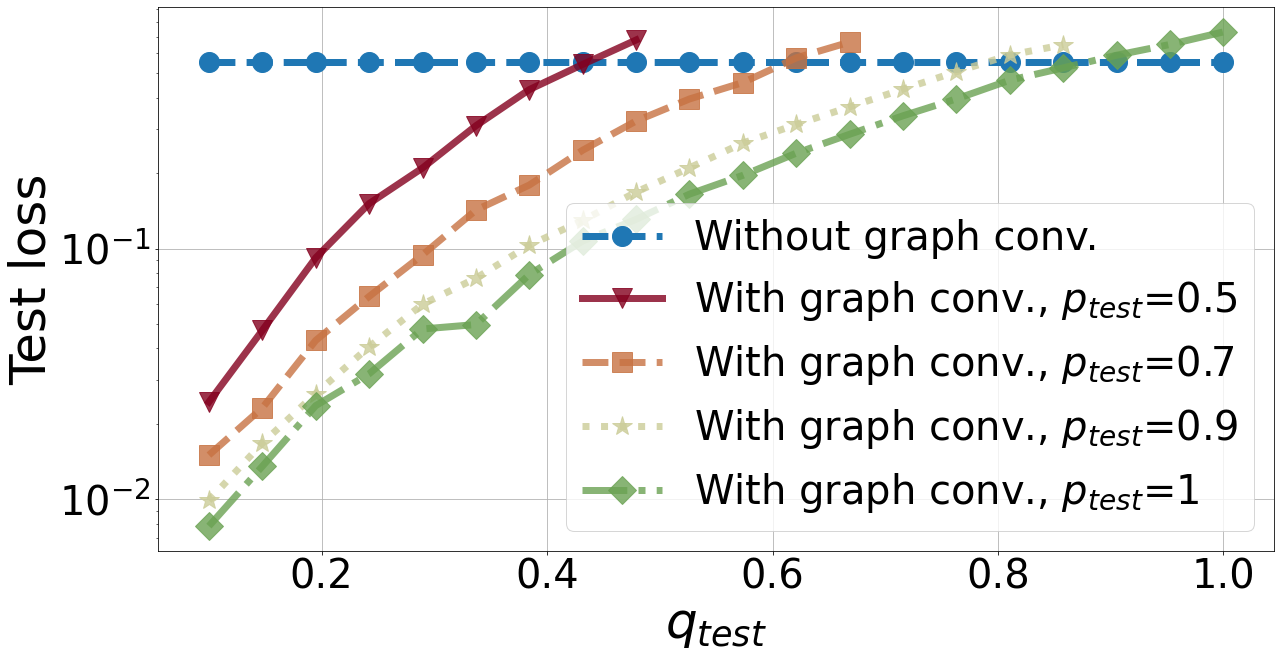

Trained on (p,q): (0.9, 0.1)


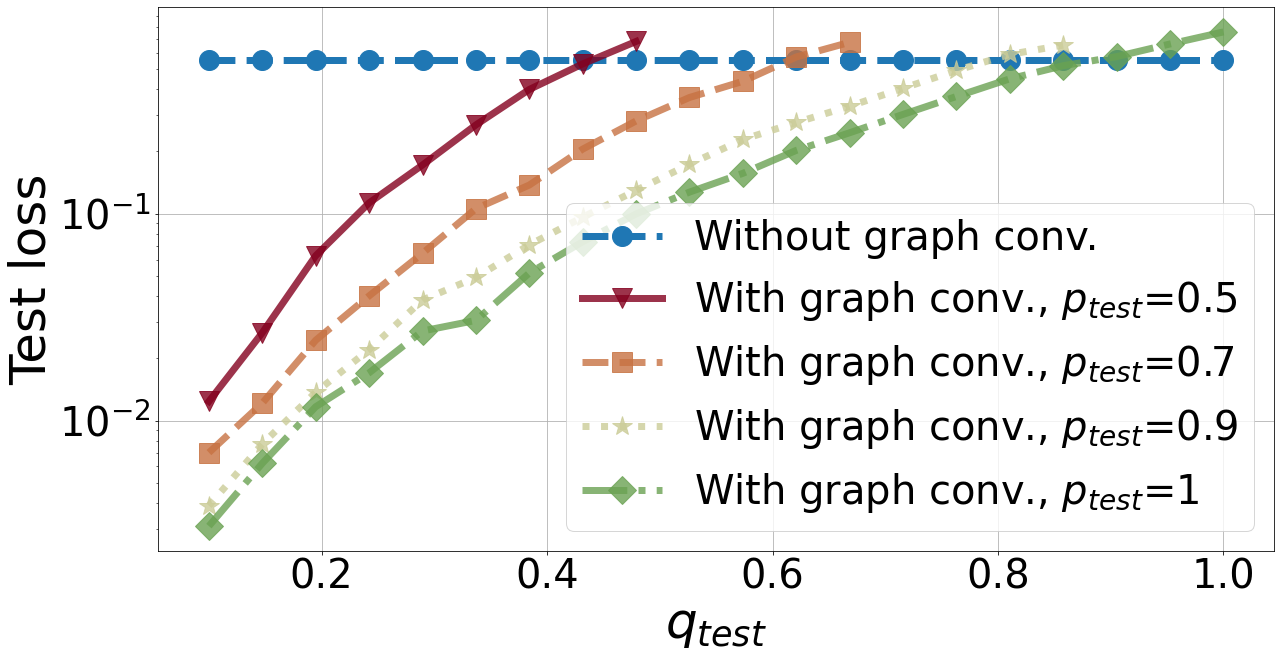

Trained on (p,q): (0.9, 0.38421052631578945)


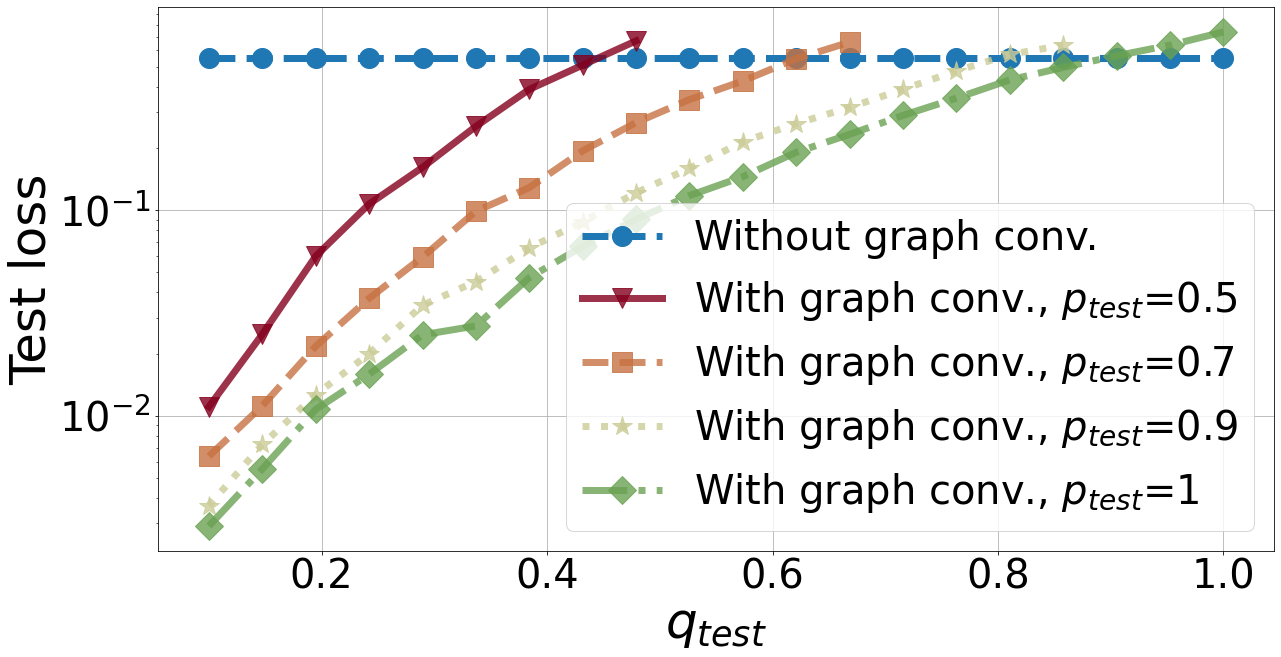

Trained on (p,q): (0.9, 0.6684210526315789)


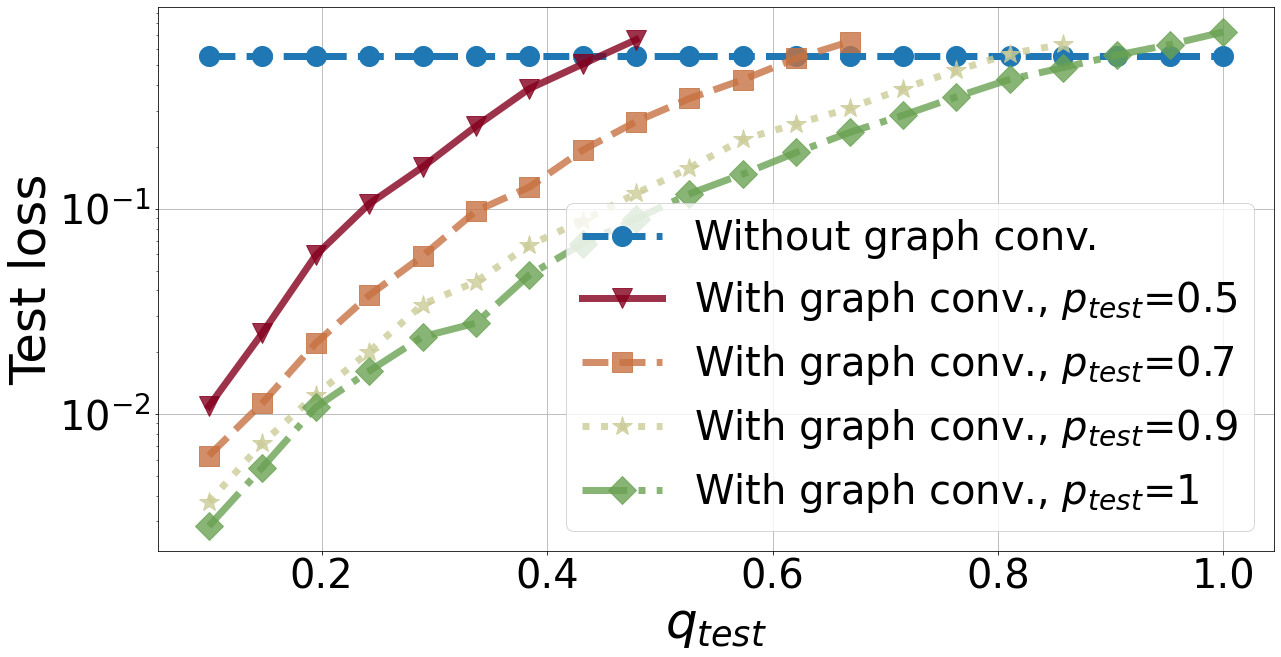

Trained on (p,q): (1, 0.1)


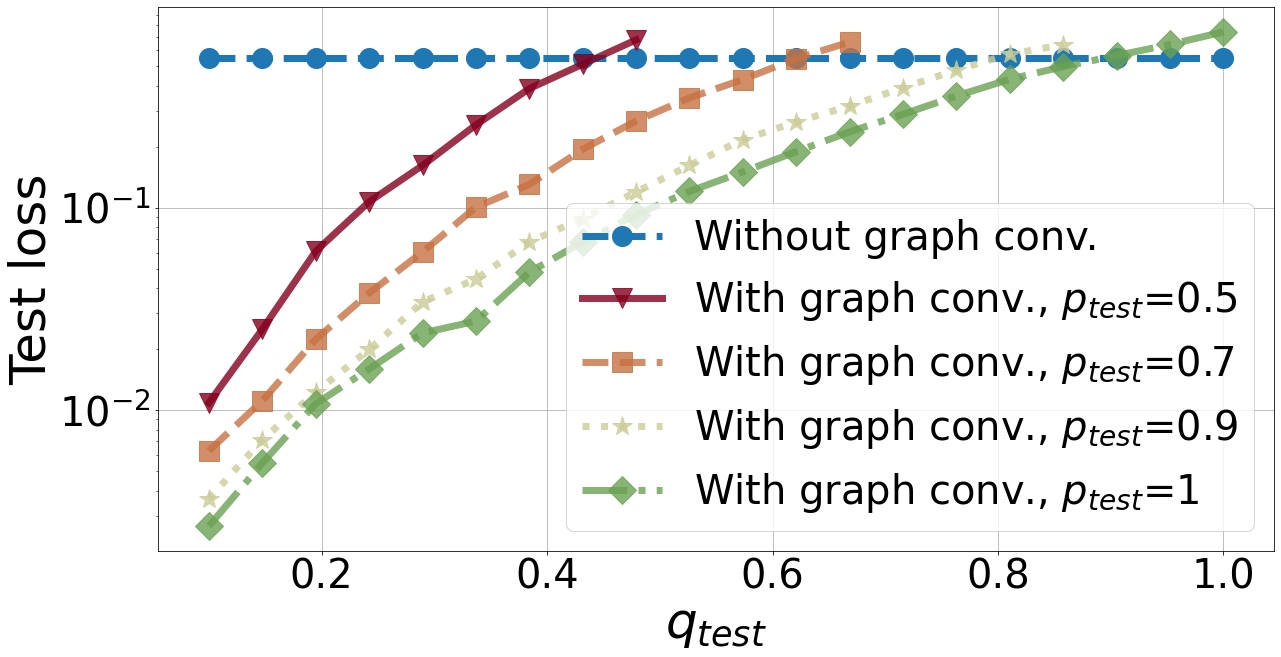

Trained on (p,q): (1, 0.38421052631578945)


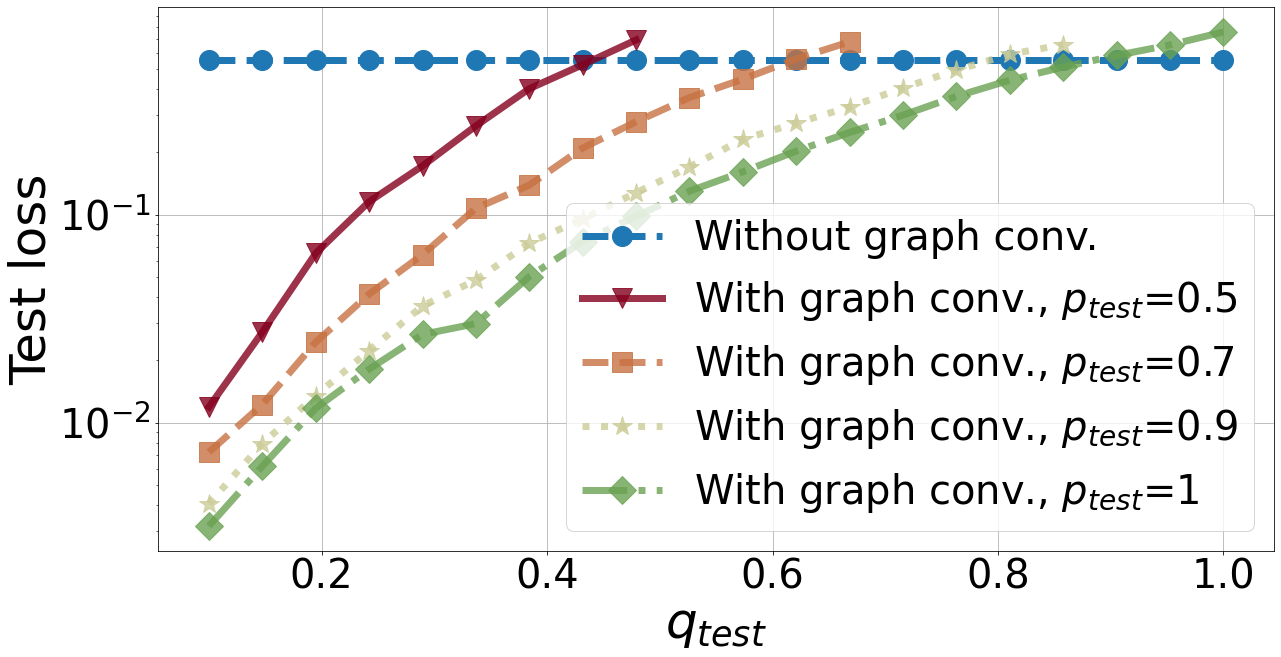

Trained on (p,q): (1, 0.6684210526315789)


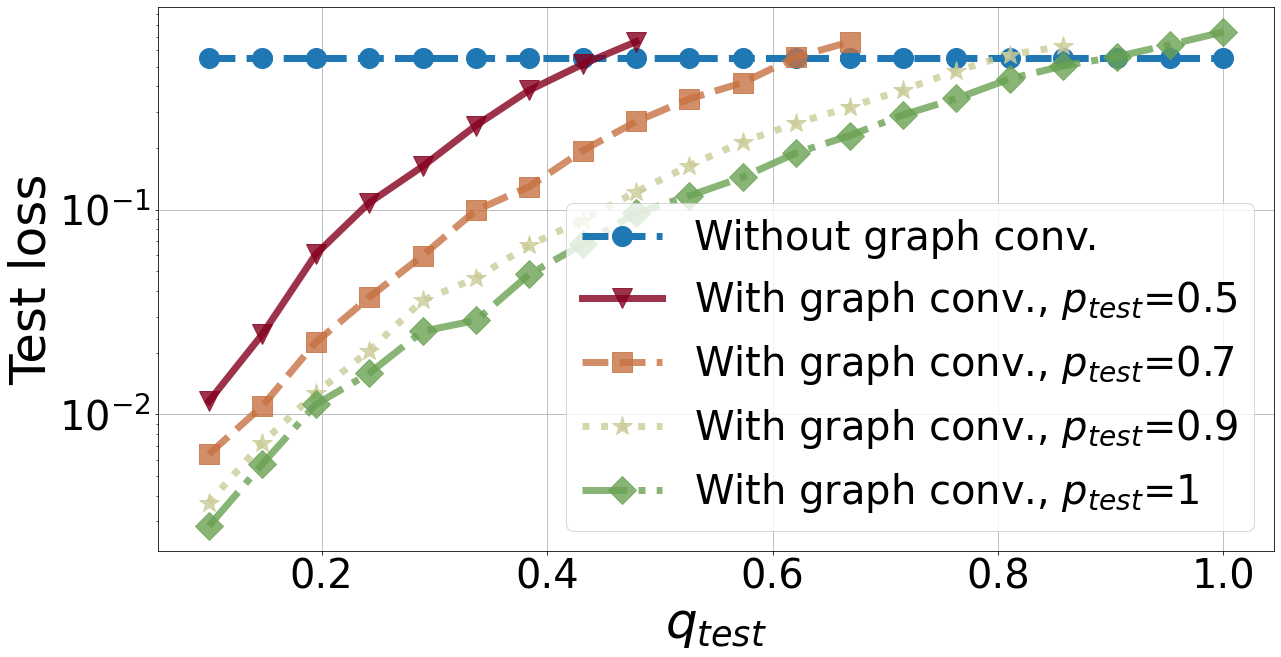

Trained on (p,q): (1, 0.9526315789473684)


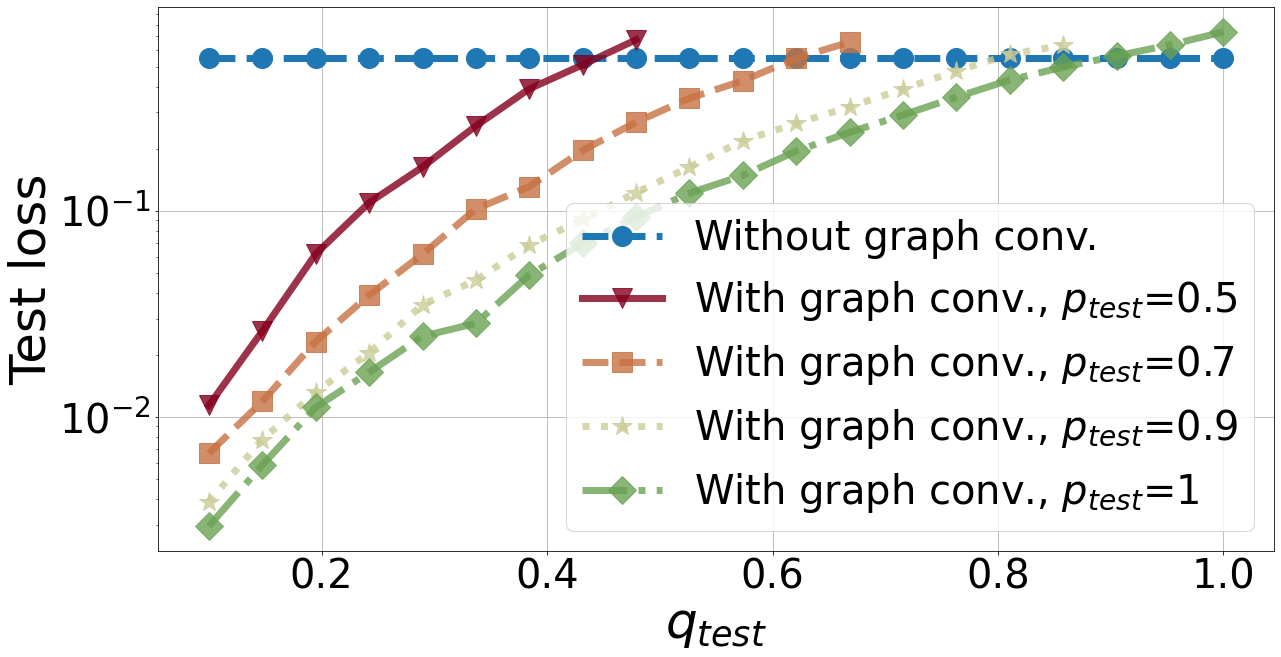

In [12]:
linestyles = ['-','--',':','-.']
markers = ['v', 's', '*', 'D']

for mu in mus:
    
    print("Distance: ", str(np.round(2*mu*np.sqrt(n_features),2)))

    means = all_means[mu]

    rqs = []
    for i in range(0,len(qs)+1,6):
        rqs.append(qs[i])
    for p, q in product(ps, rqs):

        if p < q:
            continue
            
        print("Trained on (p,q):", (p,q))

        p_lines = plots_pq[(mu,p,q)]
    
        fig = plt.figure(figsize=(20,10), facecolor=[1,1,1])
        ax = plt.axes()    
        ax.plot(qs, plots_log_test[mu], linewidth=7, linestyle= '--', marker='o', markersize=20, label='Without graph conv.')

        for ct, p2 in enumerate(ps):
            l_ = len(p_lines[p2])
            color  = np.array(plt.cm.RdYlGn(ct/len(ps)))*.8
            ax.plot(qs[0:l_], p_lines[p2], linewidth=7, color=color, linestyle=linestyles[ct], marker=markers[ct], markersize=20, label=r'With graph conv., $p_{test}$=' + str(p2))

        ax.set_xlabel(r'$q_{test}$', fontsize=50)
        ax.set_ylabel('Test loss', fontsize=50)
        ax.legend(loc='lower right', fontsize=40)
        plt.xticks(fontsize=40)
        plt.yticks(fontsize=40)
        plt.yscale('log')
        ax.grid()
        plt.show()

        fig.savefig('loss_vs_q_test_result_trained_on_n='+str(2*n) + '_p='+str(np.round(p,2)) + '_q='+str(np.round(q,2))+ '_dist=' + str(np.round(2*mu*np.sqrt(n_features),2)) + '.pdf', bbox_inches='tight')
